<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/multiclass_ChemBert_Binding_Affinity_Prediction_for_Small_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://www.kaggle.com/competitions/leash-BELKA/data)

In [42]:
!pip install pandas pyarrow
!pip install duckdb
!pip install rdkit
!pip install py3Dmol
!pip install mordred
!pip install deepchem

In [43]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os

# Create directory path for data
directory_path = "/content/data"

# Check if the directory already exists
if not os.path.exists(directory_path):
    os.mkdir(directory_path)
    print(f"Directory created at {directory_path}")
else:
    print(f"Directory already exists at {directory_path}")

Directory already exists at /content/data


In [45]:
%%time
!unzip /content/drive/MyDrive/Datasets/leash_BELKA/data.zip -d /content/data

Archive:  /content/drive/MyDrive/Datasets/leash_BELKA/data.zip
replace /content/data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/test.parquet  
  inflating: /content/data/train.csv  
  inflating: /content/data/train.parquet  
CPU times: user 4.1 s, sys: 557 ms, total: 4.66 s
Wall time: 12min 27s


In [64]:
%%time
#By Andrew D. Blevins https://www.kaggle.com/code/andrewdblevins/leash-tutorial-ecfps-and-random-forest

import duckdb
import pandas as pd

train_path = '/content/data/train.parquet'
test_path = '/content/data/test.parquet'

con = duckdb.connect()

max_limit = 1589906
limit_num = 30000

# 1589906 is the total number of binding samples
df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {limit_num})
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT {limit_num})""").df()

con.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 28s, sys: 6.39 s, total: 2min 34s
Wall time: 21.4 s


In [65]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,160286152,O=C(Nc1cc(Br)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CN(C)C(=O)C1CCC(CN)O1.Cl,Cn1cc(C(F)F)c(CN)n1,CN(C)C(=O)C1CCC(CNc2nc(NCc3nn(C)cc3C(F)F)nc(Nc...,HSA,0
1,33931022,COc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1,CN1CCN(Cc2ccccc2N)CC1,NCC(c1cccs1)N1CCOCC1,COc1ccc(C(=O)N[Dy])c(Nc2nc(NCC(c3cccs3)N3CCOCC...,sEH,0
2,188981853,O=C(Nc1ccc(C(=O)O)cc1C(F)(F)F)OCC1c2ccccc2-c2c...,Cl.Cl.NCc1ccc[n+]([O-])c1,Nc1ncnc(=O)[nH]1,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc[n+]([O-])c3)nc(N...,BRD4,0
3,290732664,O=C(O)[C@H]1CCN1C(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(N2CCOCC2)cn1,Nc1cc(Cl)ccn1,O=C(N[Dy])[C@H]1CCN1c1nc(Nc2ccc(N3CCOCC3)cn2)n...,BRD4,0
4,246336859,O=C(O)C[C@@H](Cc1ccc(Cl)cc1)NC(=O)OCC1c2ccccc2...,CCON(C)C(=O)CN.Cl,CC(C)c1nc(N)sc1Br,CCON(C)C(=O)CNc1nc(Nc2nc(C(C)C)c(Br)s2)nc(N[C@...,HSA,0


In [66]:
df.shape

(60000, 7)

<Axes: xlabel='protein_name'>

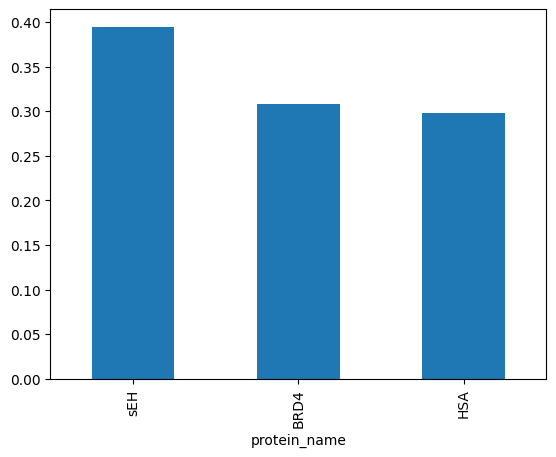

In [67]:
df['protein_name'].value_counts(normalize=True).plot(kind='bar')

### Targets

**EPHX2 (sEH)**

The first target, epoxide hydrolase 2, is encoded by the EPHX2 genetic locus, and its protein product is commonly named “soluble epoxide hydrolase”, or abbreviated to sEH. Hydrolases are enzymes that catalyze certain chemical reactions, and EPHX2/sEH also hydrolyzes certain phosphate groups. EPHX2/sEH is a potential drug target for high blood pressure and diabetes progression, and small molecules inhibiting EPHX2/sEH from earlier DEL efforts made it to clinical trials.

EPHX2/sEH was also screened with DELs, and hits predicted with ML approaches, in a recent study but the screening data were not published. We included EPHX2/sEH to allow contestants an external gut check for model performance by comparing to these previously-published results.

We screened EPHX2/sEH purchased from Cayman Chemical, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino sequence is positions 2-555 from UniProt entry [P34913](https://www.uniprot.org/uniprotkb/P34913/entry#sequences), the crystal structure can be found in PDB entry [3i28](https://www.rcsb.org/structure/3i28), and predicted structure can be found in AlphaFold2 entry [34913](https://alphafold.ebi.ac.uk/entry/P34913). Additional EPHX2/sEH crystal structures with ligands bound can be found in PDB.

In [50]:
# import py3Dmol
# view = py3Dmol.view(query='pdb:3i38')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**BRD4**

The second target, bromodomain 4, is encoded by the BRD4 locus and its protein product is also named BRD4. Bromodomains bind to protein spools in the nucleus that DNA wraps around (called histones) and affect the likelihood that the DNA nearby is going to be transcribed, producing new gene products. Bromodomains play roles in cancer progression and a number of drugs have been discovered to inhibit their activities.

BRD4 has been screened with DEL approaches previously but the screening data were not published. We included BRD4 to allow contestants to evaluate candidate molecules for oncology indications.

We screened BRD4 purchased from Active Motif, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 44-460 from UniProt entry [O60885-1](https://www.uniprot.org/uniprotkb/O60885/entry#sequences), the crystal structure (for a single domain) can be found in PDB entry [7USK](https://www.rcsb.org/structure/7USK) and predicted structure can be found in AlphaFold2 entry [O60885](https://alphafold.ebi.ac.uk/entry/O60885
). Additional BRD4 crystal structures with ligands bound can be found in PDB.

In [51]:
# view = py3Dmol.view(query='pdb:7usk')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**ALB (HSA)**


The third target, serum albumin, is encoded by the ALB locus and its protein product is also named ALB. The protein product is sometimes abbreviated as HSA, for “human serum albumin”. ALB, the most common protein in the blood, is used to drive osmotic pressure (to bring fluid back from tissues into blood vessels) and to transport many ligands, hormones, fatty acids, and more.

Albumin, being the most abundant protein in the blood, often plays a role in absorbing candidate drugs in the body and sequestering them from their target tissues. Adjusting candidate drugs to bind less to albumin and other blood proteins is a strategy to help these candidate drugs be more effective.

ALB has been screened with DEL approaches previously but the screening data were not published. We included ALB to allow contestants to build models that might have a larger impact on drug discovery across many disease types. The ability to predict ALB binding well would allow drug developers to improve their candidate small molecule therapies much more quickly than physically manufacturing many variants and testing them against ALB empirically in an iterative process.

We screened ALB purchased from Active Motif. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 25 to 609 from UniProt entry [P02768](https://www.uniprot.org/uniprotkb/P02768/entry#sequences), the crystal structure can be found in PDB entry [1AO6](https://www.ebi.ac.uk/pdbe/entry/pdb/1AO6), and predicted structure can be found in AlphaFold2 entry [P02768](https://alphafold.ebi.ac.uk/entry/P02768). Additional ALB crystal structures with ligands bound can be found in PDB.



In [52]:
# view = py3Dmol.view(query='pdb:1ao6')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

In [53]:
df['binds'].value_counts()

binds
0    30000
1    30000
Name: count, dtype: int64

In [54]:
df['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21                  5086
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21          3171
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                     817
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O              729
O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21                    627
                                                               ... 
CCS(=O)(=O)c1cc(C(=O)O)c(OC)cc1NC(=O)OCC1c2ccccc2-c2ccccc21     111
O=C(Nc1c(Cl)cc(Cl)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21              106
O=C(Nc1cc(Cl)ncc1C(=O)O)OCC1c2ccccc2-c2ccccc21                  105
O=C(O)C[C@@H]1CCCN1C(=O)OCC1c2ccccc2-c2ccccc21                  105
O=C(Nc1nc(Cl)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21                   97
Name: count, Length: 271, dtype: int64

In [55]:
df['molecule_smiles'].value_counts()

molecule_smiles
COC(=O)c1ccc2nc(Nc3nc(NCc4cncc(F)c4)nc(N4Cc5ccccc5C4C(=O)N[Dy])n3)sc2c1                 2
O=C(N[Dy])C(Cc1ccccc1)Nc1nc(NCc2nc3cc(F)ccc3o2)nc(Nc2n[nH]c3cc(F)ccc23)n1               2
O=C(N[Dy])[C@@H](CCC1CCCCC1)Nc1nc(Nc2cccc3cnccc23)nc(Nc2cccc3ocnc23)n1                  2
CCS(=O)CCNc1nc(NCc2cncc(F)c2)nc(Nc2ccc(C(=O)N[Dy])cc2)n1                                2
Cc1ccncc1Nc1nc(NCc2nccn2-c2ccccc2)nc(N[C@@H](CC(=O)N[Dy])Cc2ccc(Cl)c(Cl)c2)n1           2
                                                                                       ..
O=C(N[Dy])c1cc(Nc2nc(NCc3cnsc3)nc(NCc3cncc(F)c3)n2)ccc1[N+](=O)[O-]                     1
CCSCCNc1nc(Nc2cc(-c3cccc(Br)c3)no2)nc(Nc2c(Cl)cc(F)cc2C(=O)N[Dy])n1                     1
Cn1ccc2cc(Nc3nc(Nc4ccc(C(=O)N5CCOCC5)cc4)nc(Nc4cc(C(=O)N[Dy])ccc4Br)n3)ccc21            1
C#Cc1ccc(Nc2nc(NCC34CCCC(CO3)C4)nc(Nc3c(C(=O)N[Dy])ccnc3OC)n2)cc1                       1
O=C(N[Dy])[C@@H](Cc1ccc(Cl)cc1)Nc1nc(Nc2ccncn2)nc(Nc2cc(N3CCNCC3)ccc2[N+](=O)[O-])n1

In [56]:
df[df['binds'] == 1]['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21              4984
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21      3079
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                 719
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O          618
O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21                518
                                                           ... 
O=C(Nc1c(F)ccc(Br)c1C(=O)O)OCC1c2ccccc2-c2ccccc21             2
C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O               2
O=C(Nc1c(C(=O)O)cnn1-c1ccc(F)cc1)OCC1c2ccccc2-c2ccccc21       1
O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccccc21            1
O=C(Nc1cc(Cl)ncc1C(=O)O)OCC1c2ccccc2-c2ccccc21                1
Name: count, Length: 267, dtype: int64

In [57]:
df.isna().sum()

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

<Axes: xlabel='protein_name'>

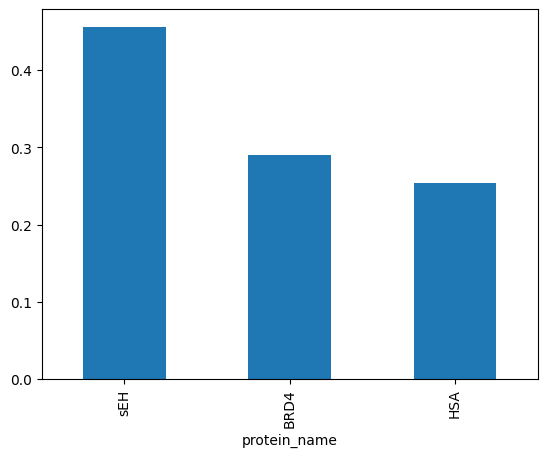

In [58]:
df[df['binds'] == 1]['protein_name'].value_counts(normalize=True).plot(kind='bar')

In [59]:
targets = pd.get_dummies(df['protein_name'])
df = pd.concat([df, targets], axis=1)

In [60]:
df

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,BRD4,HSA,sEH
0,201962608,O=C(Nc1ccc(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1ccccc1-c1csc(N)n1,Nc1ccc2nccnc2c1,Cc1ccccc1-c1csc(Nc2nc(Nc3ccc4nccnc4c3)nc(Nc3cc...,HSA,0,False,True,False
1,71570966,O=C(CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)...,NCC1CCC(F)(F)CC1,Cc1nc(N)ccc1Cl,Cc1nc(Nc2nc(NCC3CCC(F)(F)CC3)nc(N[C@@H](CCC(=O...,sEH,0,False,False,True
2,165097249,O=C(Nc1cc(C(=O)O)ccc1C(=O)O)OCC1c2ccccc2-c2ccc...,Cl.NCCC1CCCC1(F)F,Cl.Cl.NCC1(c2ccncc2)CC1,O=C(N[Dy])c1ccc(C(=O)O)c(Nc2nc(NCCC3CCCC3(F)F)...,HSA,0,False,True,False
3,288757064,O=C(O)[C@H]1CCCCN1C(=O)OCC1c2ccccc2-c2ccccc21,CC(C)Cn1cnc2c(N)nc3ccccc3c21,CSC1(CN)CCOCC1.Cl,CSC1(CNc2nc(Nc3nc4ccccc4c4c3ncn4CC(C)C)nc(N3CC...,sEH,0,False,False,True
4,159606261,O=C(Nc1cc(Br)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cl.NCC(F)(F)C(F)(F)F,CS(=O)(=O)Nc1cccc(N)c1,CS(=O)(=O)Nc1cccc(Nc2nc(NCC(F)(F)C(F)(F)F)nc(N...,BRD4,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...
59995,82573643,O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,Nc1cc(F)c(F)cc1Br,NCc1ccon1,O=C(N[Dy])C1CCC(CNc2nc(NCc3ccon3)nc(Nc3cc(F)c(...,sEH,1,False,False,True
59996,191583793,O=C(Nc1ccc(C(=O)O)cc1F)OCC1c2ccccc2-c2ccccc21,Nc1ccc(N2CCCC2=O)cc1,COc1nc(C)nc(N)n1,COc1nc(C)nc(Nc2nc(Nc3ccc(N4CCCC4=O)cc3)nc(Nc3c...,HSA,1,False,True,False
59997,82484942,O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,NCCN1CCC2(C1)OCCO2,Cl.Cl.NCc1nccn1-c1ccccc1,O=C(N[Dy])C1CCC(CNc2nc(NCCN3CCC4(C3)OCCO4)nc(N...,sEH,1,False,False,True
59998,214564880,O=C(Nc1cccc(I)c1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1cncc(F)c1,NCCC(=O)NCc1ccncc1,O=C(CCNc1nc(Nc2cncc(F)c2)nc(Nc2cccc(I)c2C(=O)N...,sEH,1,False,False,True


In [68]:
# One-hot encode the protein_name column
df = pd.concat([df, pd.get_dummies(df['protein_name'])], axis=1)

# Update the one-hot encoded columns based on the binds column
df.loc[df['binds'] == 0, ['BRD4', 'HSA', 'sEH']] = False

df['DNB'] = df['binds']==0
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,BRD4,HSA,sEH,DNB
0,160286152,O=C(Nc1cc(Br)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CN(C)C(=O)C1CCC(CN)O1.Cl,Cn1cc(C(F)F)c(CN)n1,CN(C)C(=O)C1CCC(CNc2nc(NCc3nn(C)cc3C(F)F)nc(Nc...,HSA,0,False,False,False,True
1,33931022,COc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1,CN1CCN(Cc2ccccc2N)CC1,NCC(c1cccs1)N1CCOCC1,COc1ccc(C(=O)N[Dy])c(Nc2nc(NCC(c3cccs3)N3CCOCC...,sEH,0,False,False,False,True
2,188981853,O=C(Nc1ccc(C(=O)O)cc1C(F)(F)F)OCC1c2ccccc2-c2c...,Cl.Cl.NCc1ccc[n+]([O-])c1,Nc1ncnc(=O)[nH]1,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc[n+]([O-])c3)nc(N...,BRD4,0,False,False,False,True
3,290732664,O=C(O)[C@H]1CCN1C(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(N2CCOCC2)cn1,Nc1cc(Cl)ccn1,O=C(N[Dy])[C@H]1CCN1c1nc(Nc2ccc(N3CCOCC3)cn2)n...,BRD4,0,False,False,False,True
4,246336859,O=C(O)C[C@@H](Cc1ccc(Cl)cc1)NC(=O)OCC1c2ccccc2...,CCON(C)C(=O)CN.Cl,CC(C)c1nc(N)sc1Br,CCON(C)C(=O)CNc1nc(Nc2nc(C(C)C)c(Br)s2)nc(N[C@...,HSA,0,False,False,False,True


In [69]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors

In [70]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit import RDLogger

# Suppress RDKit warnings and info messages
RDLogger.DisableLog('rdApp.*')

# Create canonical smiles to check for duplicates
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return False

# Example usage with a DataFrame column
def process_dataframe(df):
    canonical_smiles_list = []
    for smiles in tqdm(df['molecule_smiles'], desc="Processing DataFrame"):
        canonical_smiles_list.append(canonical_smiles(smiles))
    df['canonical_smiles'] = canonical_smiles_list
    return df

# Process the DataFrame
df = process_dataframe(df)
df.head()

Processing DataFrame:   0%|          | 0/60000 [00:00<?, ?it/s]

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,BRD4,HSA,sEH,DNB,canonical_smiles
0,160286152,O=C(Nc1cc(Br)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CN(C)C(=O)C1CCC(CN)O1.Cl,Cn1cc(C(F)F)c(CN)n1,CN(C)C(=O)C1CCC(CNc2nc(NCc3nn(C)cc3C(F)F)nc(Nc...,HSA,0,False,False,False,True,CN(C)C(=O)C1CCC(CNc2nc(NCc3nn(C)cc3C(F)F)nc(Nc...
1,33931022,COc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1,CN1CCN(Cc2ccccc2N)CC1,NCC(c1cccs1)N1CCOCC1,COc1ccc(C(=O)N[Dy])c(Nc2nc(NCC(c3cccs3)N3CCOCC...,sEH,0,False,False,False,True,COc1ccc(C(=O)N[Dy])c(Nc2nc(NCC(c3cccs3)N3CCOCC...
2,188981853,O=C(Nc1ccc(C(=O)O)cc1C(F)(F)F)OCC1c2ccccc2-c2c...,Cl.Cl.NCc1ccc[n+]([O-])c1,Nc1ncnc(=O)[nH]1,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc[n+]([O-])c3)nc(N...,BRD4,0,False,False,False,True,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc[n+]([O-])c3)nc(N...
3,290732664,O=C(O)[C@H]1CCN1C(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(N2CCOCC2)cn1,Nc1cc(Cl)ccn1,O=C(N[Dy])[C@H]1CCN1c1nc(Nc2ccc(N3CCOCC3)cn2)n...,BRD4,0,False,False,False,True,O=C(N[Dy])[C@H]1CCN1c1nc(Nc2ccc(N3CCOCC3)cn2)n...
4,246336859,O=C(O)C[C@@H](Cc1ccc(Cl)cc1)NC(=O)OCC1c2ccccc2...,CCON(C)C(=O)CN.Cl,CC(C)c1nc(N)sc1Br,CCON(C)C(=O)CNc1nc(Nc2nc(C(C)C)c(Br)s2)nc(N[C@...,HSA,0,False,False,False,True,CCON(C)C(=O)CNc1nc(Nc2nc(C(C)C)c(Br)s2)nc(N[C@...


In [77]:
df['molecule_smiles'].value_counts()

molecule_smiles
O=C(N[Dy])c1ccc(Nc2nc(NCCCCN3CCCC3)nc(NCc3cncc(F)c3)n2)c(O)c1                                2
COc1ccc(Nc2nc(NC[C@@H]3OCCN(C)[C@H]3c3cnn(C)c3)nc(Nc3ccc(N4CCCC4=O)cc3)n2)c(C(=O)N[Dy])c1    2
CCOC(=O)c1ncccc1Nc1nc(Nc2ccc3c(c2)C(=O)CCC3)nc(Nc2ncc(C(=O)N[Dy])s2)n1                       2
CC(CNc1nc(NCc2cncc(F)c2)nc(Nc2cc(C(=O)N[Dy])ccc2Br)n1)N1CCC1                                 2
Cc1ccc(C[C@H](Nc2nc(NCc3cncc(F)c3)nc(Nc3ccc(N4CCN(C)CC4)c(F)c3)n2)C(=O)N[Dy])cc1             2
                                                                                            ..
CCOC(=O)c1csc(Nc2nc(Nc3nnc(C(=O)OCC)o3)nc(Nc3c(C(=O)N[Dy])cnn3-c3ccc(F)cc3)n2)n1             1
Cc1nc(Cl)ccc1Nc1nc(Nc2nccc(-c3cccnc3)n2)nc(N2Cc3ccccc3C[C@@H]2C(=O)N[Dy])n1                  1
CS(=O)(=O)c1ccc(Nc2nc(NCC3Cc4ccccc4C3)nc(Nc3nc(C(F)(F)F)c(C(=O)N[Dy])s3)n2)cc1F              1
O=C(NCCNc1nc(NCCC2CN(c3ncnc4[nH]ncc34)c3ccccc32)nc(Nc2ccc(Cl)c(C(=O)N[Dy])c2)n1)c1cnccn1     1
N#Cc1ccc(C[C@H](CC(=O)N[Dy])Nc2nc(

In [81]:
smiles_that_bind = []
for i in range(len(df)):
  if df['binds'].iloc[i] == 1:
    smiles_that_bind.append(df['canonical_smiles'].iloc[i])
len(smiles_that_bind)

30000

In [83]:
rows_to_drop = []
for i in range(len(df)):
  if (df['binds'].iloc[i] == 0) & (df['canonical_smiles'].iloc[i] in smiles_that_bind):
    rows_to_drop.append(i)

In [84]:
len(rows_to_drop)

3

In [89]:
df = df.drop(rows_to_drop, axis=0)

In [90]:
df = df.drop_duplicates(subset=['canonical_smiles','protein_name'], keep='first')

<Axes: >

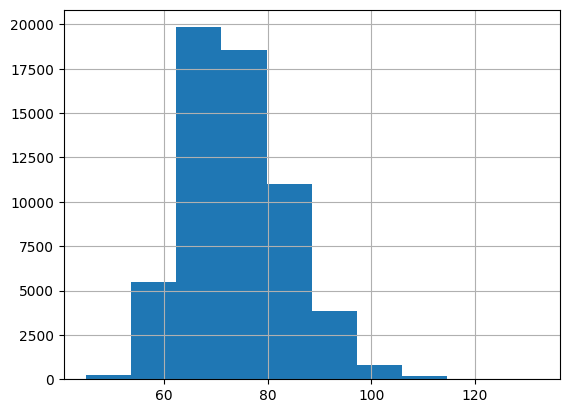

In [91]:
df['canonical_smiles_len'] = df['canonical_smiles'].apply(len)
df['canonical_smiles_len'].hist()

In [92]:
%%time
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
import os

# Hyperparameters
epochs = 30
batch_size = 256
learning_rate = 1e-4

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=4).to(device)

model_save_dir = "/content/drive/MyDrive/models/chembert_BELKA"

os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, 'best_model_multi.pth')

# Define a custom dataset class
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['canonical_smiles']
        label = self.dataframe.iloc[idx][['BRD4', 'HSA', 'sEH','DNB']].values.argmax()  # Use argmax to convert one-hot to label
        return smiles, label

    def collate_fn(self, batch):
        # Tokenize and convert to tensors
        tokenized_batch = [self.tokenizer.encode(smiles, add_special_tokens=True) for smiles, _ in batch]
        padded_batch = pad_sequence([torch.tensor(tokens) for tokens in tokenized_batch],
                                    batch_first=True, padding_value=self.tokenizer.pad_token_id)

        labels = torch.tensor([label for _, label in batch], dtype=torch.long)

        return padded_batch, labels

# Split the data into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Create datasets and data loaders
train_dataset = SMILESDataset(train_df, tokenizer)
val_dataset = SMILESDataset(test_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1, verbose=True)
loss_fn = torch.nn.CrossEntropyLoss()

# Training and validation loop

train_losses = []
val_losses = []
train_acc = []
val_acc = []

best_epoch = 0
best_val_loss = float('inf')
best_val_acc = 0

for epoch in tqdm(range(epochs)):

    train_loss = 0
    train_correct = 0
    train_count = 0

    model.train()
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits  # Shape: [batch_size, num_labels]

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_count += labels.size(0)

    avg_train_loss = train_loss / train_count
    train_losses.append(avg_train_loss)
    train_accuracy = train_correct / train_count
    train_acc.append(train_accuracy)

    # Evaluation loop
    val_loss = 0
    val_correct = 0
    val_count = 0
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [batch_size, num_labels]

            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_count += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / val_count
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_count
    val_acc.append(val_accuracy)

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_epoch = epoch
      best_val_acc = val_accuracy
      torch.save(model.state_dict(), model_save_path)

    scheduler.step(avg_val_loss)

    print(f'Epoch: {epoch + 1}/{epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  3%|▎         | 1/30 [01:24<40:57, 84.74s/it]

Epoch: 1/30
Train Loss: 0.0034
Train Accuracy: 0.6576
Validation Loss: 0.0025
Validation Accuracy: 0.7494


  7%|▋         | 2/30 [02:48<39:12, 84.01s/it]

Epoch: 2/30
Train Loss: 0.0024
Train Accuracy: 0.7690
Validation Loss: 0.0023
Validation Accuracy: 0.7799


 10%|█         | 3/30 [04:12<37:47, 83.99s/it]

Epoch: 3/30
Train Loss: 0.0022
Train Accuracy: 0.7874
Validation Loss: 0.0021
Validation Accuracy: 0.7913


 13%|█▎        | 4/30 [05:36<36:23, 83.98s/it]

Epoch: 4/30
Train Loss: 0.0020
Train Accuracy: 0.7957
Validation Loss: 0.0021
Validation Accuracy: 0.7928


 17%|█▋        | 5/30 [06:59<34:53, 83.74s/it]

Epoch: 5/30
Train Loss: 0.0020
Train Accuracy: 0.8026
Validation Loss: 0.0022
Validation Accuracy: 0.7820


 20%|██        | 6/30 [08:23<33:29, 83.73s/it]

Epoch: 6/30
Train Loss: 0.0019
Train Accuracy: 0.8073
Validation Loss: 0.0021
Validation Accuracy: 0.7903


 23%|██▎       | 7/30 [09:46<32:05, 83.70s/it]

Epoch: 7/30
Train Loss: 0.0019
Train Accuracy: 0.8099
Validation Loss: 0.0019
Validation Accuracy: 0.8025


 27%|██▋       | 8/30 [11:10<30:43, 83.79s/it]

Epoch: 8/30
Train Loss: 0.0018
Train Accuracy: 0.8138
Validation Loss: 0.0020
Validation Accuracy: 0.8010


 30%|███       | 9/30 [12:34<29:18, 83.75s/it]

Epoch: 9/30
Train Loss: 0.0018
Train Accuracy: 0.8167
Validation Loss: 0.0019
Validation Accuracy: 0.8047


 33%|███▎      | 10/30 [13:58<27:55, 83.76s/it]

Epoch: 10/30
Train Loss: 0.0018
Train Accuracy: 0.8194
Validation Loss: 0.0019
Validation Accuracy: 0.8065


 37%|███▋      | 11/30 [15:22<26:32, 83.82s/it]

Epoch: 11/30
Train Loss: 0.0018
Train Accuracy: 0.8191
Validation Loss: 0.0019
Validation Accuracy: 0.8107


 40%|████      | 12/30 [16:46<25:10, 83.93s/it]

Epoch: 12/30
Train Loss: 0.0017
Train Accuracy: 0.8248
Validation Loss: 0.0020
Validation Accuracy: 0.7965


 43%|████▎     | 13/30 [18:09<23:44, 83.79s/it]

Epoch: 13/30
Train Loss: 0.0017
Train Accuracy: 0.8230
Validation Loss: 0.0019
Validation Accuracy: 0.7983


 47%|████▋     | 14/30 [19:33<22:21, 83.84s/it]

Epoch: 14/30
Train Loss: 0.0017
Train Accuracy: 0.8277
Validation Loss: 0.0019
Validation Accuracy: 0.8074


 50%|█████     | 15/30 [20:57<20:56, 83.75s/it]

Epoch: 15/30
Train Loss: 0.0017
Train Accuracy: 0.8294
Validation Loss: 0.0019
Validation Accuracy: 0.8067


 53%|█████▎    | 16/30 [22:20<19:32, 83.71s/it]

Epoch: 16/30
Train Loss: 0.0016
Train Accuracy: 0.8307
Validation Loss: 0.0019
Validation Accuracy: 0.8037


 57%|█████▋    | 17/30 [23:45<18:10, 83.90s/it]

Epoch: 17/30
Train Loss: 0.0016
Train Accuracy: 0.8316
Validation Loss: 0.0019
Validation Accuracy: 0.8088


 60%|██████    | 18/30 [25:09<16:47, 83.93s/it]

Epoch: 18/30
Train Loss: 0.0016
Train Accuracy: 0.8323
Validation Loss: 0.0019
Validation Accuracy: 0.7984


 63%|██████▎   | 19/30 [26:33<15:23, 83.93s/it]

Epoch: 19/30
Train Loss: 0.0016
Train Accuracy: 0.8341
Validation Loss: 0.0019
Validation Accuracy: 0.8046


 67%|██████▋   | 20/30 [27:57<14:00, 84.08s/it]

Epoch: 20/30
Train Loss: 0.0016
Train Accuracy: 0.8344
Validation Loss: 0.0019
Validation Accuracy: 0.8014


 70%|███████   | 21/30 [29:21<12:37, 84.13s/it]

Epoch: 21/30
Train Loss: 0.0016
Train Accuracy: 0.8368
Validation Loss: 0.0019
Validation Accuracy: 0.8077


 73%|███████▎  | 22/30 [30:46<11:13, 84.17s/it]

Epoch: 22/30
Train Loss: 0.0016
Train Accuracy: 0.8380
Validation Loss: 0.0019
Validation Accuracy: 0.8052


 77%|███████▋  | 23/30 [32:10<09:48, 84.12s/it]

Epoch: 23/30
Train Loss: 0.0015
Train Accuracy: 0.8384
Validation Loss: 0.0018
Validation Accuracy: 0.8123


 80%|████████  | 24/30 [33:34<08:25, 84.26s/it]

Epoch: 24/30
Train Loss: 0.0015
Train Accuracy: 0.8382
Validation Loss: 0.0019
Validation Accuracy: 0.8065


 83%|████████▎ | 25/30 [34:59<07:01, 84.32s/it]

Epoch: 25/30
Train Loss: 0.0015
Train Accuracy: 0.8395
Validation Loss: 0.0018
Validation Accuracy: 0.8097


 87%|████████▋ | 26/30 [36:23<05:37, 84.41s/it]

Epoch: 26/30
Train Loss: 0.0015
Train Accuracy: 0.8420
Validation Loss: 0.0019
Validation Accuracy: 0.8071


 90%|█████████ | 27/30 [37:48<04:13, 84.39s/it]

Epoch: 27/30
Train Loss: 0.0015
Train Accuracy: 0.8413
Validation Loss: 0.0019
Validation Accuracy: 0.8037


 93%|█████████▎| 28/30 [39:12<02:48, 84.36s/it]

Epoch: 28/30
Train Loss: 0.0015
Train Accuracy: 0.8428
Validation Loss: 0.0018
Validation Accuracy: 0.8090


 97%|█████████▋| 29/30 [40:36<01:24, 84.24s/it]

Epoch: 29/30
Train Loss: 0.0015
Train Accuracy: 0.8439
Validation Loss: 0.0019
Validation Accuracy: 0.8071


100%|██████████| 30/30 [42:00<00:00, 84.01s/it]

Epoch: 30/30
Train Loss: 0.0015
Train Accuracy: 0.8428
Validation Loss: 0.0019
Validation Accuracy: 0.8078
CPU times: user 42min 2s, sys: 8.62 s, total: 42min 11s
Wall time: 42min 1s


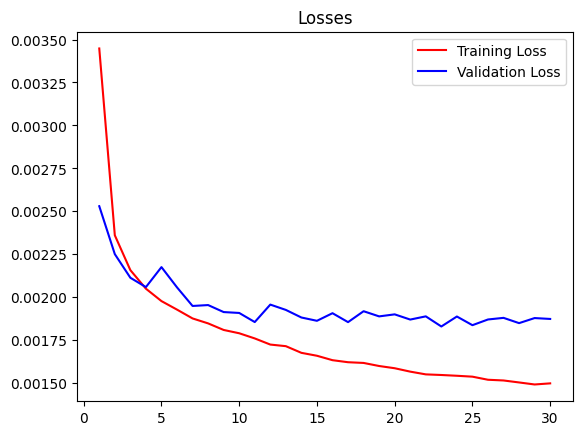

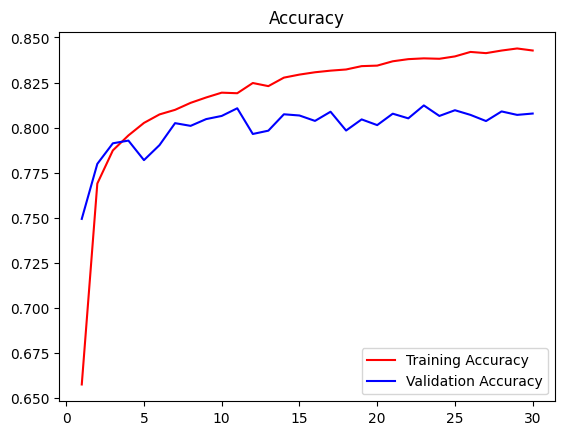

In [93]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, epochs+1), train_losses, c='r',label='Training Loss')
plt.plot(np.arange(1, epochs+1), val_losses, c='b', label='Validation Loss')
plt.legend()
plt.title("Losses")
plt.show()

plt.plot(np.arange(1, epochs+1), train_acc, c='r',label='Training Accuracy')
plt.plot(np.arange(1, epochs+1), val_acc, c='b', label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

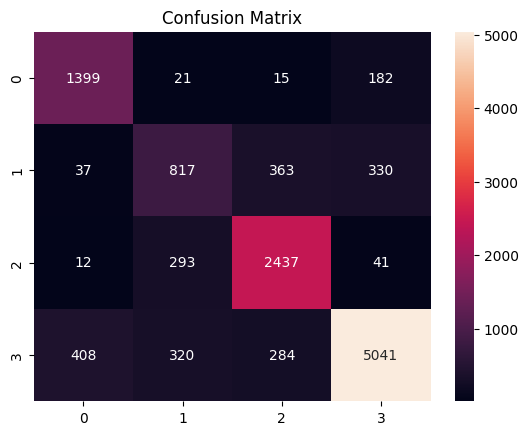

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1617
           1       0.56      0.53      0.55      1547
           2       0.79      0.88      0.83      2783
           3       0.90      0.83      0.87      6053

    accuracy                           0.81     12000
   macro avg       0.75      0.78      0.76     12000
weighted avg       0.81      0.81      0.81     12000



In [94]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(true_labels, pred_labels))

In [ ]:
from datetime import datetime
model.load_state_dict(torch.load(model_save_path))
current_date = datetime.now().strftime("%Y%m%d_%H")
model_filename = f"modelmulticlass_{best_val_acc:.4f}acc_{best_val_loss:.4f}loss_{epochs}epochs_{learning_rate}lr_{batch_size}batch_{current_date}.pth"
new_model_save_path = os.path.join(model_save_dir, model_filename)
torch.save(model.state_dict(), new_model_save_path)